# US DFM Nowcasting Model

This Notebook contains a DFM mixed frequency nowcasting model for US Quarterly GDP in Python, using the latest edition of the [FRED MD database](https://research.stlouisfed.org/econ/mccracken/fred-databases/). The model is adapted from the one set up by [Chad Fulton in 2020](http://www.chadfulton.com/topics/statespace_large_dynamic_factor_models.html).

### Brief overview

In this notebook, we'll use 123 monthly variables and 1 quarterly variable (GDP) from the [FRED-MD / FRED-QD dataset](https://research.stlouisfed.org/econ/mccracken/fred-databases/) (McCracken and Ng, 2016).

**Statistical model**:

The statistical model and the EM-algorithm used for parameter estimation are described in:

- Bańbura and Modugno (2014), "Maximum likelihood estimation of factor models on datasets with arbitrary pattern of missing data." ([Working paper](https://core.ac.uk/download/pdf/6684705.pdf), [Published](https://onlinelibrary.wiley.com/doi/full/10.1002/jae.2306?casa_token=tX0xS_49OXcAAAAA%3Aocw-egTRztTVg643NCHRCQUs_OGCPMTS78Qds4gk2nN6ViFjOMZYSDVip-0eeDwQCpvaTOTqjof5_wKI)), and
- Bańbura et al. (2011), "Nowcasting" ([Working paper](https://core.ac.uk/download/pdf/6518537.pdf), [Handbook chapter](https://www.oxfordhandbooks.com/view/10.1093/oxfordhb/9780195398649.001.0001/oxfordhb-9780195398649-e-8))

As in these papers, the basic specification starts from the typical "static form" of the dynamic factor model:

$$
\begin{aligned}
y_t & = \Lambda f_t + \epsilon_t \\
f_t & = A_1 f_{t-1} + \dots + A_p f_{t-p} + u_t
\end{aligned}
$$

The [New York Fed Staff Nowcast](https://www.newyorkfed.org/research/policy/nowcast.html) is an application of this same dynamic factor model and (EM algorithm) estimation method. Although they use a different dataset, their underlying framework is the same as that used in this notebook.

For more details on the New York Fed Staff Nowcast model and results, see [Bok et al. (2018)](https://www.newyorkfed.org/research/staff_reports/sr830).

In [1]:
import types
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

### Dataset

In this notebook, we estimate a dynamic factor model on a large panel of economic data released at a monthly frequency, along with GDP, which is only released at a quarterly frequency. The monthly datasets that we'll be using come from [FRED-MD database](https://research.stlouisfed.org/econ/mccracken/fred-databases/) (McCracken and Ng, 2016), and we will take real GDP from the companion FRED-QD database.

**Data transformations**

The assumptions of the dynamic factor model in this notebook require that the factors and observed variables are stationary. However, this dataset contains raw economic series that clearly violate that assumptions – for example, many of them show distinct trends. As is typical in these exercises, we therefore transform the variables to induce stationarity. In particular, the FRED-MD and FRED-QD datasets include suggested transformations (coded 1-7, which typically apply differences or percentage change transformations) which we apply.

The exact details are in the `transform` function, below:

In [2]:
def transform(column, transforms):
    transformation = transforms[column.name]
    # For quarterly data like GDP, we will compute
    # annualized percent changes
    mult = 4 if column.index.freqstr[0] == 'Q' else 1
    
    # 1 => No transformation
    if transformation == 1:
        pass
    # 2 => First difference
    elif transformation == 2:
        column = column.diff()
    # 3 => Second difference
    elif transformation == 3:
        column = column.diff().diff()
    # 4 => Log
    elif transformation == 4:
        column = np.log(column)
    # 5 => Log first difference, multiplied by 100
    #      (i.e. approximate percent change)
    #      with optional multiplier for annualization
    elif transformation == 5:
        column = np.log(column).diff() * 100 * mult
    # 6 => Log second difference, multiplied by 100
    #      with optional multiplier for annualization
    elif transformation == 6:
        column = np.log(column).diff().diff() * 100 * mult
    # 7 => Exact percent change, multiplied by 100
    #      with optional annualization
    elif transformation == 7:
        column = ((column / column.shift(1))**mult - 1.0) * 100
        
    return column


**Outliers**

Following McCracken and Ng (2016), we remove outliers (setting their value to missing), defined as observations that are more than 10 times the interquartile range from the series mean.

During the first half of 2020, there are a number of series which include extreme observations, many of which would be excluded by this outlier test. Because these observations are likely to be informative about real GDP in 2020, we only remove outliers for the period 1959-01 through 2019-12.

The details of outlier removal are in the `remove_outliers` function, below:

In [3]:
def remove_outliers(dta):
    # Compute the mean and interquartile range
    mean = dta.mean()
    iqr = dta.quantile([0.25, 0.75]).diff().T.iloc[:, 1]
    
    # Replace entries that are more than 10 times the IQR
    # away from the mean with NaN (denotes a missing entry)
    mask = np.abs(dta) > mean + 10 * iqr
    treated = dta.copy()
    treated[mask] = np.nan

    return treated

**Loading the data**

The `load_fredmd_data` function, below, performs the following actions, once for the FRED-MD dataset and once for the FRED-QD dataset:

1. Based on the `vintage` argument, it downloads a particular vintage of these datasets from the base URL https://files.stlouisfed.org/files/htdocs/fred-md into the `orig_[m|q]` variable.
2. Extracts the column describing which transformation to apply into the `transform_[m|q]` (and, for the quarterly dataset, also extracts the column describing which factor an earlier paper assigned each variable to).
3. Extracts the observation date (from the "sasdate" column) and uses it as the index of the dataset.
4. Applies the transformations from step (2).
5. Removes outliers for the period 1959-01 through 2019-12.

Finally, these are collected into an easy-to-use object (the `SimpleNamespace` object) and returned.

In [4]:
def load_fredmd_data(vintage):
    base_url = 'https://files.stlouisfed.org/files/htdocs/fred-md'
    
    # - FRED-MD --------------------------------------------------------------
    # 1. Download data
    orig_m = (pd.read_csv(f'{base_url}/monthly/{vintage}.csv')
                .dropna(how='all'))
    
    # 2. Extract transformation information
    transform_m = orig_m.iloc[0, 1:]
    orig_m = orig_m.iloc[1:]

    # 3. Extract the date as an index
    orig_m.index = pd.PeriodIndex(orig_m.sasdate.tolist(), freq='M')
    orig_m.drop('sasdate', axis=1, inplace=True)

    # 4. Apply the transformations
    dta_m = orig_m.apply(transform, axis=0,
                         transforms=transform_m)

    # 5. Remove outliers (but not in 2020)
    dta_m.loc[:'2019-12'] = remove_outliers(dta_m.loc[:'2019-12'])

    # - FRED-QD --------------------------------------------------------------
    # 1. Download data
    orig_q = (pd.read_csv(f'{base_url}/quarterly/{vintage}.csv')
                .dropna(how='all'))

    # 2. Extract factors and transformation information
    factors_q = orig_q.iloc[0, 1:]
    transform_q = orig_q.iloc[1, 1:]
    orig_q = orig_q.iloc[2:]

    # 3. Extract the date as an index
    orig_q.index = pd.PeriodIndex(orig_q.sasdate.tolist(), freq='Q')
    orig_q.drop('sasdate', axis=1, inplace=True)

    # 4. Apply the transformations
    dta_q = orig_q.apply(transform, axis=0,
                          transforms=transform_q)

    # 5. Remove outliers (but not in 2020)
    dta_q.loc[:'2019Q4'] = remove_outliers(dta_q.loc[:'2019Q4'])
    
    # - Output datasets ------------------------------------------------------
    return types.SimpleNamespace(
        orig_m=orig_m, orig_q=orig_q,
        dta_m=dta_m, transform_m=transform_m,
        dta_q=dta_q, transform_q=transform_q, factors_q=factors_q)

In [5]:
# Load the current dataset
data = load_fredmd_data("current")

**Adding Definitions**

Here we load definitions of the variables from CSV files, and create a dictionary containing a mapping from the file names to the definitions. We subset the downloaded data to contain only series for we we have definitions. 

In [6]:
# Definitions from the Appendix for FRED-MD variables
defn_m = pd.read_csv('../data/FRED/fredmd_definitions.csv', encoding_errors='ignore')
defn_m.index = defn_m.fred
defn_m = defn_m.loc[data.dta_m.columns.intersection(defn_m.fred), :]
map_m = defn_m['description'].to_dict()

# Definitions from the Appendix for FRED-QD variables
defn_q = pd.read_csv('../data/FRED/fredqd_definitions.csv', encoding_errors='ignore')
defn_q.index = defn_q.fred
defn_q = defn_q.loc[data.dta_q.columns.intersection(defn_q.fred), :]
map_q = defn_q['description'].to_dict()

# Example of the information in these files:
defn_m.head()

,id,tcode,ttype,fred,description,gsi,gsi:description,group,edited
RPI,1,5,First difference of natural log: ln(x)-ln(x-1),RPI,Real Personal Income,M_14386177,PI,Output and Income,False
W875RX1,2,5,First difference of natural log: ln(x)-ln(x-1),W875RX1,Real personal income ex transfer receipts,M_145256755,PI less transfers,Output and Income,False
DPCERA3M086SBEA,3,5,First difference of natural log: ln(x)-ln(x-1),DPCERA3M086SBEA,Real personal consumption expenditures,M_123008274,Real Consumption,"Consumption, Orders, and Inventories",False
CMRMTSPLx,4,5,First difference of natural log: ln(x)-ln(x-1),CMRMTSPLx,Real Manu. and Trade Industries Sales,M_110156998,M&T sales,"Consumption, Orders, and Inventories",True
RETAILx,5,5,First difference of natural log: ln(x)-ln(x-1),RETAILx,Retail and Food Services Sales,M_130439509,Retail sales,"Consumption, Orders, and Inventories",True


<AxesSubplot: title={'center': 'Real Gross Domestic Product, 3 Decimal (Billions of Chained 2012 Dollars)'}>

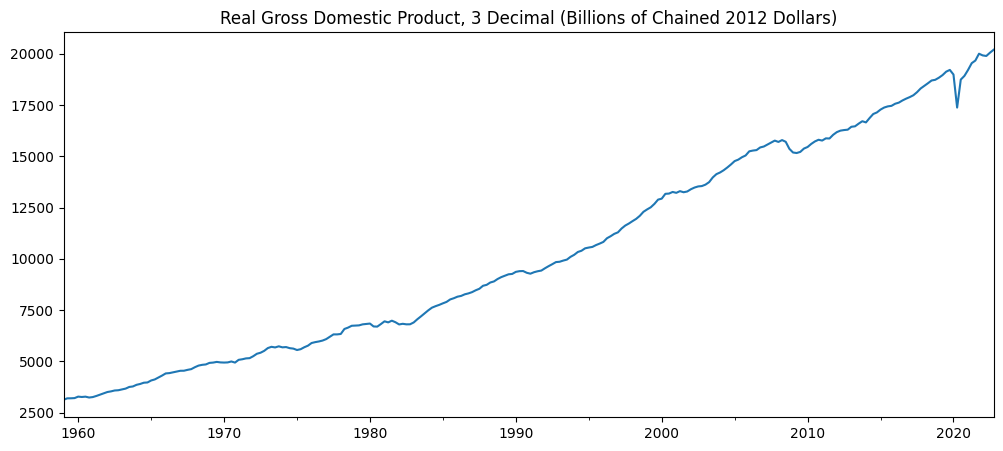

In [7]:
# Plotting GDP
data.orig_q.GDPC1.plot(title = map_q["GDPC1"], figsize = (12, 5))

<AxesSubplot: title={'center': 'Real GDP Growth (%)'}>

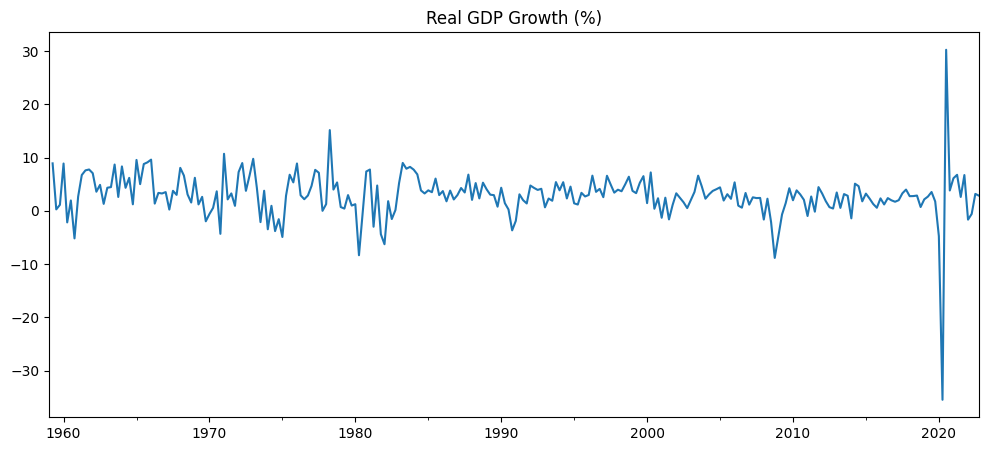

In [8]:
data.dta_q.GDPC1.plot(title = "Real GDP Growth (%)", figsize = (12, 5))

To aid interpretation of the results, we'll replace the names of our dataset with the "description" field.

In [9]:
# Replace the names of the columns in each monthly and quarterly dataset
data.orig_m = data.orig_m[map_m.keys()].rename(columns = map_m)
data.dta_m = data.dta_m[map_m.keys()].rename(columns = map_m)
data.orig_q = data.orig_q[map_q.keys()].rename(columns = map_q)
data.dta_q = data.dta_q[map_q.keys()].rename(columns = map_q)

**Data groups**

Below, we get the groups for each series from the definition files above, and then show how many of the series that we'll be using fall into each of the groups.

We'll also re-order the series by group, to make it easier to interpret the results.

Since we're including the quarterly real GDP variable in our analysis, we need to assign it to one of the groups in the monthly dataset. It fits best in the "Output and income" group.

In [10]:
# Get the mapping of variable id to group name, for monthly variables
groups = defn_m[['description', 'group']].copy()

# Add real GDP (our quarterly variable) into the "Output and Income" group
gdp_description = defn_q.loc['GDPC1', 'description']
groups = pd.concat([groups, pd.DataFrame([{'description': gdp_description, 'group': 'Output and Income'}])], 
                   ignore_index=True)

# Display the number of variables in each group
(groups.groupby('group', sort=False)
       .count()
       .rename({'description': '# series in group'}, axis=1))

,# series in group
group,
Output and Income,16
"Consumption, Orders, and Inventories",10
Labor Market,31
Housing,10
Money and Credit,12
Stock Market,4
Interest and Exchange Rates,21
Prices,20


In [11]:
# Saving Data
data.orig_m.to_csv("../data/FRED/monthly.csv")
data.dta_m.to_csv("../data/FRED/monthly_transformed.csv")
data.orig_q.to_csv("../data/FRED/quarterly.csv")
data.dta_q.to_csv("../data/FRED/quarterly_transformed.csv")
groups.to_csv("../data/FRED/groups.csv")

### Model specification

**Factor specification**

Based on screeplots calculated for the overall dataset and within each group, we opt for 2 global factors and 1 factor for the different groups, which evolve by (vector) autoregressive processes of order 1-4:

In [12]:
# Construct the variable => list of factors dictionary
factors = {row['description']: ['Global', row['group']]
           for ix, row in groups.iterrows()}

# Check that we have the desired output for "Real personal income"
print(factors['Real Personal Income'])

['Global', 'Output and Income']


**Factor multiplicities**

The `factor_multiplicities` argument defaults to `1`, but it can be passed a dictionary with keys equal to factor names (from the `factors` argument) and values equal to an integer. Note that the default for each factor is 1, so we only include in this dictionary factors that have multiplicity greater than 1.

In [13]:
factor_multiplicities = {'Global': 2}
                         # 'Consumption, Orders, and Inventories': 2, 
                         # 'Interest and Exchange Rates': 2

**Factor orders**

Finally, we need to specify the lag order of the (vector) autoregressions that govern the dynamics of the factors. This is done via the `factor_orders` argument. The `factor_orders` argument also defaults to `1`,

In [14]:
factor_orders = {'Global': 4, 
                 'Consumption, Orders, and Inventories': 2, #4, 
                 'Housing': 2,
                 'Interest and Exchange Rates': 2, #3,
                 'Money and Credit': 2,
                 'Output and Income': 2}

**Creating the model**

Given the factor specification, above, we can finish the model specification and create the model object.

The `DynamicFactorMQ` model class has the following primary arguments:

1. `endog` and `endog_quarterly`

   These arguments are used to pass the observed variables to the model. There are two ways to provide the data:

2. `factors`, `factor_orders`, and `factor_multiplicities`

   These arguments were described above.


3. `idiosyncratic_ar1`

   The `DynamicFactorMQ` model allows the idiosyncratic disturbance terms to be modeled as independent AR(1) processes or as iid variables. The default is `idiosyncratic_ar1=True`, which can be useful in modeling some of the idiosyncratic serial correlation, for example for forecasting.

In [15]:
# Get the baseline monthly and quarterly datasets
start = '1990' # Start in 1990
endog_m = data.dta_m.loc[start:, :]
gdp_description = defn_q.loc['GDPC1', 'description']
endog_q = data.dta_q.loc[start:, [gdp_description]]

# Construct the dynamic factor model
model = sm.tsa.DynamicFactorMQ(
    endog_m, endog_quarterly=endog_q,
    factors=factors, factor_orders=factor_orders,
    factor_multiplicities=factor_multiplicities)

# Another model without separate blocks but 9 global factors
model_global = sm.tsa.DynamicFactorMQ(
    endog_m, endog_quarterly=endog_q,
    factors = 1, 
    factor_orders = 4, 
    factor_multiplicities= 9) 

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:443: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.factor_block_orders.append(default_block_orders))


In [16]:
# model.summary()
# model_global.summary()

In [17]:
# Fit blocked model
results = model.fit(disp=10) # same as fit_em()

EM start iterations, llf=-38995
EM iteration 10, llf=-35948, convergence criterion=0.00025504
EM iteration 20, llf=-35850, convergence criterion=0.00039249
EM iteration 30, llf=-35766, convergence criterion=5.666e-05
EM iteration 40, llf=-35758, convergence criterion=1.3827e-05
EM iteration 50, llf=-35754, convergence criterion=7.5768e-06
EM iteration 60, llf=-35752, convergence criterion=4.6447e-06
EM iteration 70, llf=-35751, convergence criterion=2.9412e-06
EM iteration 80, llf=-35750, convergence criterion=1.8957e-06
EM iteration 90, llf=-35749, convergence criterion=1.2455e-06
EM converged at iteration 96, llf=-35749, convergence criterion=9.7961e-07 < tolerance=1e-06


In [18]:
# Fit global model
results_global = model_global.fit(disp=10)

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1947: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


EM start iterations, llf=-37924
EM iteration 10, llf=-32955, convergence criterion=0.00047944
EM iteration 20, llf=-32907, convergence criterion=5.6104e-05
EM iteration 30, llf=-32896, convergence criterion=2.0497e-05
EM iteration 40, llf=-32891, convergence criterion=1.0377e-05
EM iteration 50, llf=-32889, convergence criterion=6.5538e-06
EM iteration 60, llf=-32887, convergence criterion=4.812e-06
EM iteration 70, llf=-32886, convergence criterion=3.7855e-06
EM iteration 80, llf=-32885, convergence criterion=3.0947e-06
EM iteration 90, llf=-32884, convergence criterion=2.5916e-06
EM iteration 100, llf=-32883, convergence criterion=2.2075e-06
EM iteration 110, llf=-32882, convergence criterion=1.9053e-06
EM iteration 120, llf=-32882, convergence criterion=1.662e-06
EM iteration 130, llf=-32881, convergence criterion=1.4616e-06
EM iteration 140, llf=-32881, convergence criterion=1.293e-06
EM iteration 150, llf=-32880, convergence criterion=1.1486e-06
EM iteration 160, llf=-32880, conve

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     Dynamic Factor Results                                     
================================================================================================
Dep. Variable:     "Real Personal Income", and 123 more   No. Observations:                  396
Model:                             Dynamic Factor Model   Log Likelihood              -35749.201
                               + 10 factors in 9 blocks   AIC                          72818.403
                                + Mixed frequency (M/Q)   BIC                          75446.136
                                  + AR(1) idiosyncratic   HQIC                         73859.430
Date:                                  Sat, 25 Feb 2023   EM Iterations                       96
Time:                                          10:50:09                                         
Sample:                                      01-31-1990                                         
                                           - 12-31-2022                                         
Covariance Type:                           Not computed                                         
                                                                                                          Observation equation:                                                                                                           
==========================================================================================================================================================================================================================================
           Factor loadings:   Global.1   Global.2 Consumption, Orders, and Inventories     Housing Interest and Exchange Rates Money and Credit Output and Income Labor Market Stock Market      Prices    idiosyncratic: AR(1)       var.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
       Real Personal Income      -0.04      -0.01                                    .           .                           .                .             -0.11            .            .           .                   -0.40       0.71
Real personal income ex ...       0.11       0.05                                    .           .                           .                .              0.01            .            .           .                   -0.14       0.66
Real personal consumptio...       0.16      -0.05                                -0.25           .                           .                .                 .            .            .           .                   -0.13       0.13
Real Manu. and Trade Ind...       0.15      -0.03                                -0.26           .                           .                .                 .            .            .           .                   -0.29       0.26
Retail and Food Services...       0.14      -0.09                                -0.27           .                           .                .                 .            .            .           .                   -0.23       0.17
                   IP Index       0.17       0.02                                    .           .                           .                .             -0.16            .            .           .                   -0.19       0.06
IP: Final Products and N...       0.17       0.00                                    .           .                           .                .             -0.14            .            .           .                   -0.23       0.07
IP: Final Products (Mark...       0.17      -0.00                                    .           .                           .                .             -0.16            .            .           .    

In [20]:
results_global.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     Dynamic Factor Results                                     
================================================================================================
Dep. Variable:     "Real Personal Income", and 123 more   No. Observations:                  396
Model:                             Dynamic Factor Model   Log Likelihood              -32879.761
                                + 9 factors in 1 blocks   AIC                          69225.522
                                + Mixed frequency (M/Q)   BIC                          76125.312
                                  + AR(1) idiosyncratic   HQIC                         71959.007
Date:                                  Sat, 25 Feb 2023   EM Iterations                      162
Time:                                          10:50:09                                         
Sample:                                      01-31-1990                                         
                                           - 12-31-2022                                         
Covariance Type:                           Not computed                                         
                                                                       Observation equation:                                                                        
====================================================================================================================================================================
           Factor loadings:        0.1        0.2        0.3         0.4         0.5        0.6        0.7        0.8        0.9    idiosyncratic: AR(1)        var.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
       Real Personal Income      -0.04      -0.01       0.07        0.06       -0.05      -0.02       0.04      -0.02      -0.01                   -0.45        0.63
Real personal income ex ...       0.11       0.05       0.02        0.00       -0.00       0.03       0.03      -0.01      -0.00                   -0.18        0.62
Real personal consumptio...       0.16      -0.05       0.03       -0.03        0.05       0.04       0.00       0.01       0.02                   -0.23        0.17
Real Manu. and Trade Ind...       0.15      -0.03       0.07       -0.02        0.02       0.00       0.02       0.02       0.01                   -0.32        0.30
Retail and Food Services...       0.14      -0.09       0.03       -0.01        0.03       0.05       0.02       0.02       0.00                   -0.23        0.29
                   IP Index       0.17       0.02       0.07       -0.00       -0.03      -0.06       0.01      -0.01      -0.01                   -0.17        0.04
IP: Final Products and N...       0.17       0.00       0.07       -0.01       -0.01      -0.05       0.02       0.02       0.02                   -0.41        0.03
IP: Final Products (Mark...       0.17      -0.00       0.07       -0.02       -0.01      -0.06       0.02       0.03       0.05                   -0.37        0.05
         IP: Consumer Goods       0.15      -0.02       0.09       -0.02       -0.01      -0.07       0.01       0.04       0.07                   -0.39        0.14
IP: Durable Consumer Goo...       0.16      -0.01       0.07       -0.04        0.00      -0.05       0.00       0.03       0.06                   -0.20        0.13
IP: Nondurable Consumer ...       0.08      -0.01       0.06        0.01       -0.00      -0.05       0.01       0.03       0.06                   -0.30        0.65
     IP: Business Equipment       0.17       0.01       0.05       -0.02       -0.01      -0.04       0.03       0.02       0.01                    0.13        0.14
              IP: Materials       0.15       0.05       0.07        0.00       -0.05      -0.07       0.00      -0.05      -0.06                   -

### Estimated factors

In addition to the estimates of the parameters, the `results` object contains the estimates of the latent factors. These are most conveniently accessed through the `factors` attribute. This attribute in turn contains four sub-attributes:

- `smoothed`: estimates of the factors, conditional on the full dataset (also called "smoothed" or "two-sided" estimates)
- `smoothed_cov`: covariance matrix of the factor estimates, conditional on the full dataset
- `filtered`: estimates of the factors, where the estimate at time $t$ only uses information through time $t$ (also called "filtered" or "one-sided" estimates
- `filtered_cov`: covariance matrix of the factor estimates, where the estimate at time $t$ only uses information through time $t$

As an example, in the next cell we plot three of the smoothed factors and 95% confidence intervals.

**Note**: The estimated factors are not identified without additional assumptions that this model does not impose (see for example Bańbura and Modugno, 2014, for details). As a result, it can be difficult to interpet the factors themselves. (Despite this, the space spanned by the factors *is* identified, so that forecasting and nowcasting exercises, like those we discuss later, are unambiguous).

In [21]:
# [x for x in dir(results) if not x.startswith("_")]

In [22]:
def plot_factors(results, factor_names):
    # Get estimates of the global and labor market factors,
    # conditional on the full dataset ("smoothed")
    mean = results.factors.smoothed[factor_names]

    # Compute 95% confidence intervals
    from scipy.stats import norm
    std = pd.concat([results.factors.smoothed_cov.loc[name, name]
                    for name in factor_names], axis=1)
    crit = norm.ppf(1 - 0.05 / 2)
    lower = mean - crit * std
    upper = mean + crit * std

    with sns.color_palette('deep'):
        fig, ax = plt.subplots(figsize=(14, 6))
        mean.plot(ax=ax)
        
        for name in factor_names:
            ax.fill_between(mean.index, lower[name], upper[name], alpha=0.3)
        
        ax.set(title='Estimated factors: smoothed estimates and 95% confidence intervals')
        fig.tight_layout();

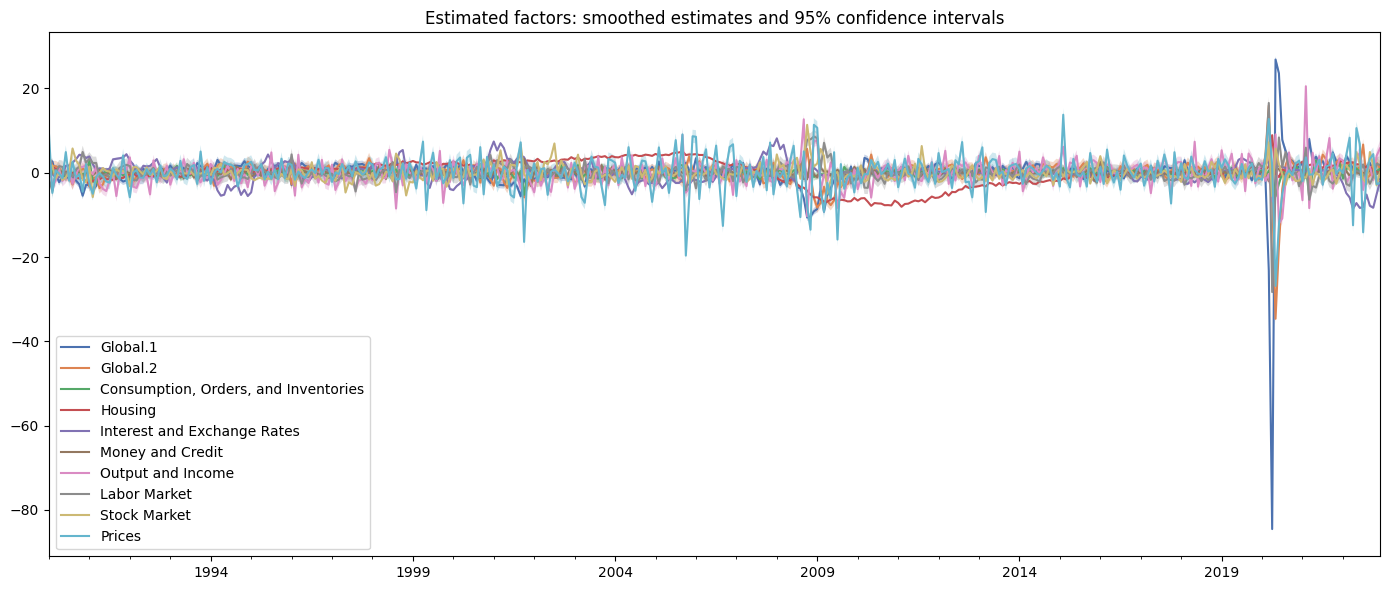

In [23]:
factor_names = results.factors.smoothed.columns.to_list() # ['Global.1', 'Global.2', 'Labor Market']
plot_factors(results, factor_names)

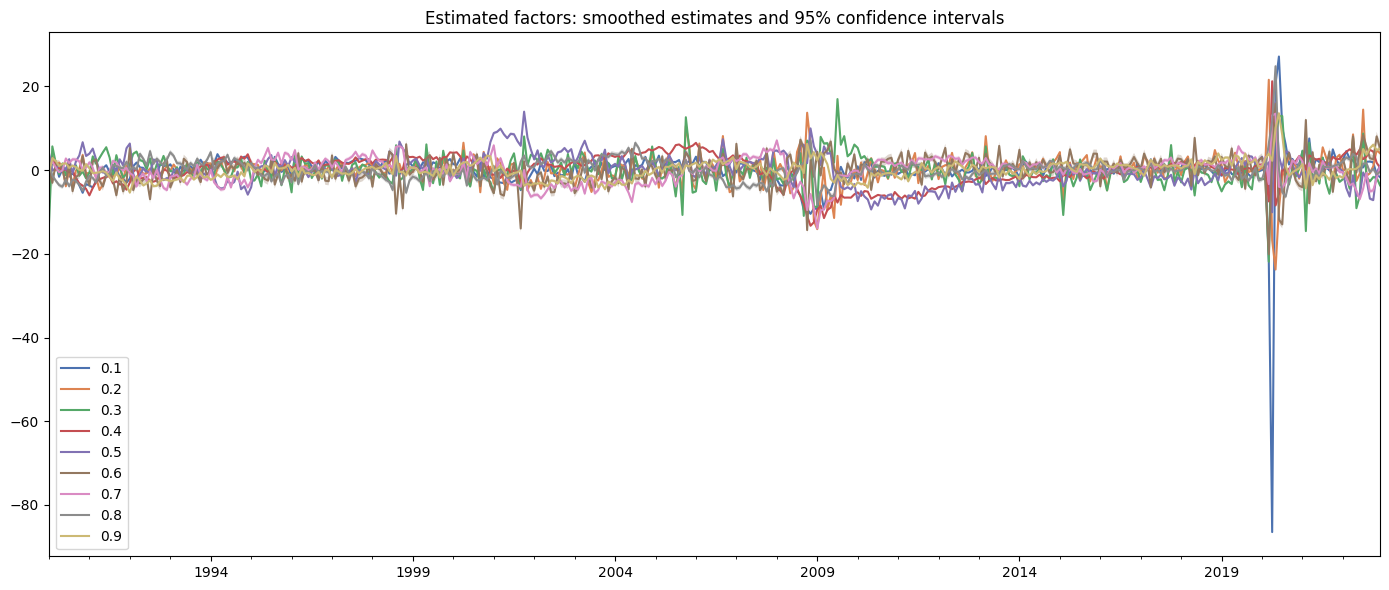

In [24]:
plot_factors(results_global, results_global.factors.smoothed.columns.to_list())

#### Explanatory power of the factors

One way to examine how the factors relate to the observed variables is to compute the explanatory power that each factor has for each variable, by regressing each variable on a constant plus one or more of the smoothed factor estimates and storing the resulting $R^2$, or "coefficient of determination", value.

**Computing $R^2$**

The `get_coefficients_of_determination` method in the results object has three options for the `method` argument:

- `method='individual'` retrieves the $R^2$ value for each observed variable regressed on each individual factor (plus a constant term)
- `method='joint'` retrieves the $R^2$ value for each observed variable regressed on all factors that the variable loads on
- `method='cumulative'` retrieves the $R^2$ value for each observed variable regressed on an expanding set of factors. The expanding set begins with the $R^2$ from a regression of each variable on the first factor that the variable loads on (as it appears in, for example, the summary tables above) plus a constant. For the next factor in the list, the $R^2$ is computed by a regression on the first two factors (assuming that a given variable loads on both factors).

**Example:** top 10 variables explained by the global factors

Below, we compute according to the `method='individual'` approach, and then show the top 10 observed variables that are explained (individually) by each of the two global factors.

In [25]:
rsquared = results.get_coefficients_of_determination(method='individual')
factor_names = ['Global.1', 'Global.2']

top_ten = []
for factor_name in factor_names:
    top_factor = (rsquared[factor_name].sort_values(ascending=False)
                                       .iloc[:10].round(2).reset_index())
    top_factor.columns = pd.MultiIndex.from_product([
        [f'Top ten variables explained by {factor_name}'],
        ['Variable', r'$R^2$']])
    top_ten.append(top_factor)
pd.concat(top_ten, axis=1)

Top ten variables explained by Global.1        \
                                           Variable $R^2$   
0                      All Employees: Total nonfarm  0.88   
1         All Employees: Goods-Producing Industries  0.88   
2       All Employees: Service-Providing Industries  0.86   
3  All Employees: Trade, Transportation & Utilities  0.85   
4                               Civilian Employment  0.84   
5                      All Employees: Manufacturing  0.84   
6                       All Employees: Retail Trade  0.83   
7                        Civilian Unemployment Rate  0.83   
8                   All Employees: Nondurable goods  0.81   
9                           IP: Manufacturing (SIC)  0.81   

             Top ten variables explained by Global.2        
                                            Variable $R^2$  
0                    Commercial and Industrial Loans  0.31  
1         Total Business: Inventories to Sales Ratio  0.25  
2  Real Gross Domestic Product, 3 Decimal (Billio...  0.24  
3                     Retail and Food Services Sales  0.24  
4                         Total Business Inventories  0.22  
5                   Avg Weekly Hours : Manufacturing  0.21  
6                 Crude Oil, spliced WTI and Cushing  0.21  
7                        PPI: Intermediate Materials  0.20  
8                Personal Cons. Expend.: Chain Index  0.19  
9                       PPI: Finished Consumer Goods  0.18

**Plotting $R^2$**

When there are a large number of observed variables, it is often easier to plot the $R^2$ values for each variable. This can be done using the `plot_coefficients_of_determination` method in the results object. It accepts the same `method` arguments as the `get_coefficients_of_determination` method, above.

Below, we plot the $R^2$ values from the "individual" regressions, for each factor. Because there are so many variables, this graphical tool is best for identifying trends overall and within groups, and we do not display the names of the variables on the x-axis label.

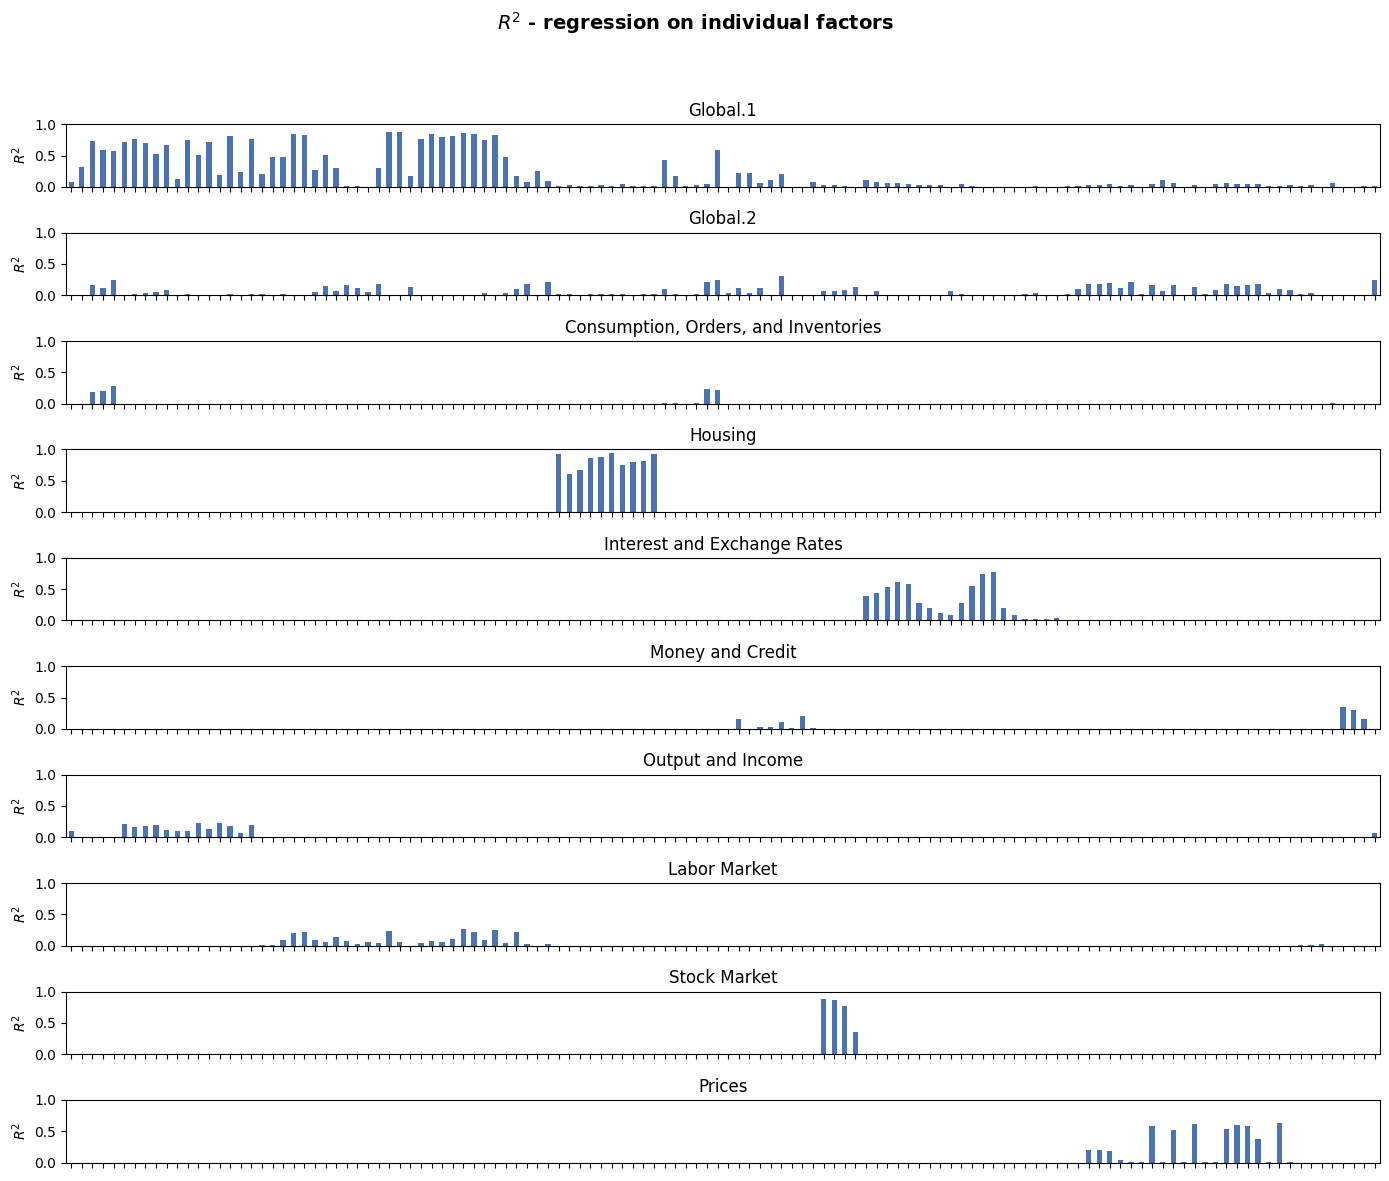

In [26]:
with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='individual', figsize=(14, 12))
    fig.suptitle(r'$R^2$ - regression on individual factors', fontsize=14, fontweight=600)
    fig.tight_layout(rect=[0, 0, 1, 0.95]);

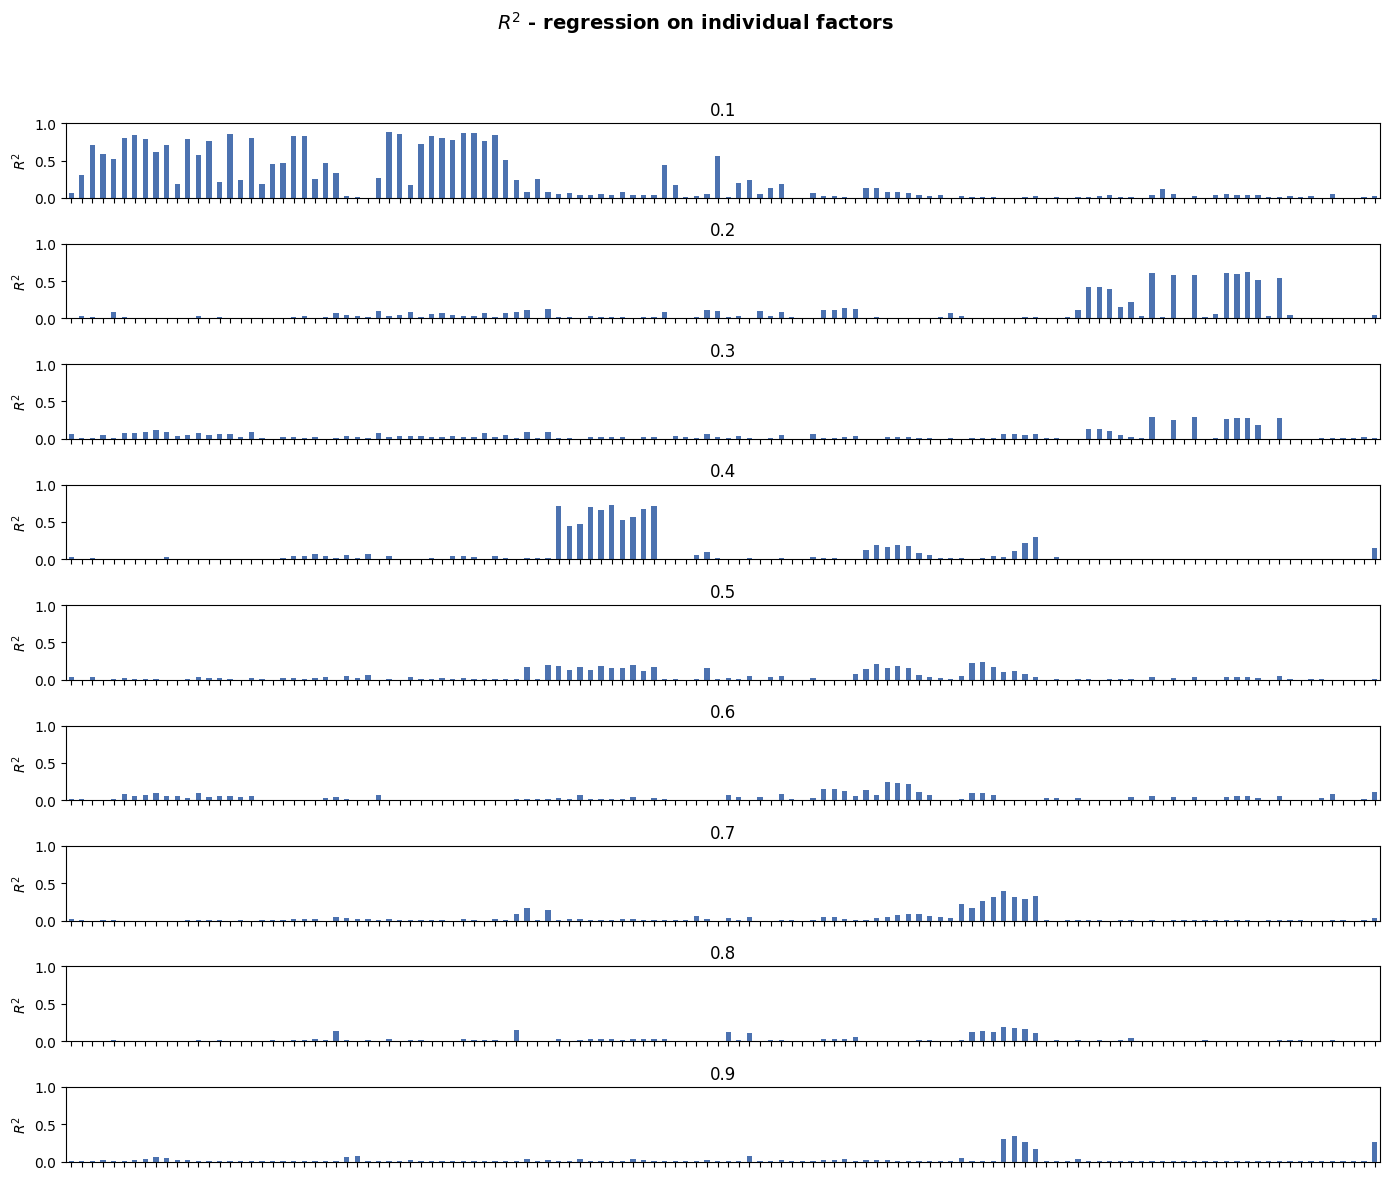

In [27]:
with sns.color_palette('deep'):
    fig = results_global.plot_coefficients_of_determination(method='individual', figsize=(14, 12))
    fig.suptitle(r'$R^2$ - regression on individual factors', fontsize=14, fontweight=600)
    fig.tight_layout(rect=[0, 0, 1, 0.95]);

Alternatively, we might look at the overall explanatory value to a given variable of all factors that the variable loads on. To do that, we can use the same function but with `method='joint'` .

To make it easier to identify patterns, we add in shading and labels to identify the different groups of variables, as well as our only quarterly variable, GDP.

In [28]:
def plot_r2_joint(results):
    group_counts = defn_m[['description', 'group']]
    group_counts = group_counts[group_counts['description'].isin(data.dta_m.columns)]
    group_counts = group_counts.groupby('group', sort=False).count()['description'].cumsum()

    with sns.color_palette('deep'):
        fig = results.plot_coefficients_of_determination(method='joint', figsize=(14, 3));

        # Add in group labels
        ax = fig.axes[0]
        ax.set_ylim(0, 1.2)
        for i in np.arange(1, len(group_counts), 2):
            start = 0 if i == 0 else group_counts[i - 1]
            end = group_counts[i] + 1
            ax.fill_between(np.arange(start, end) - 0.6, 0, 1.2, color='k', alpha=0.1)
        for i in range(len(group_counts)):
            start = 0 if i == 0 else group_counts[i - 1]
            end = group_counts[i]
            n = end - start
            text = group_counts.index[i]
            if len(text) > n:
                text = text[:n - 3] + '...'

            ax.annotate(text, (start + n / 2, 1.1), ha='center')

        # Add label for GDP
        ax.set_xlim(-1.5, model.k_endog + 0.5)
        ax.annotate('GDP', (model.k_endog - 1.1, 1.05), ha='left', rotation=90)

        fig.tight_layout();

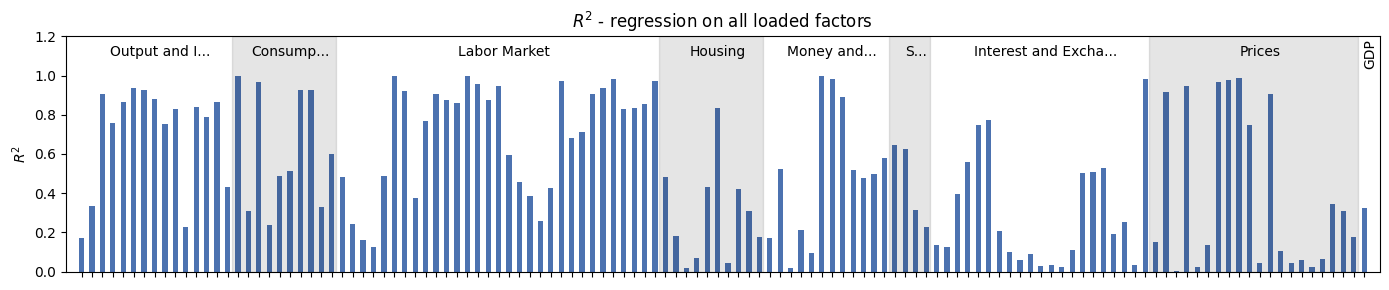

In [29]:
plot_r2_joint(results)

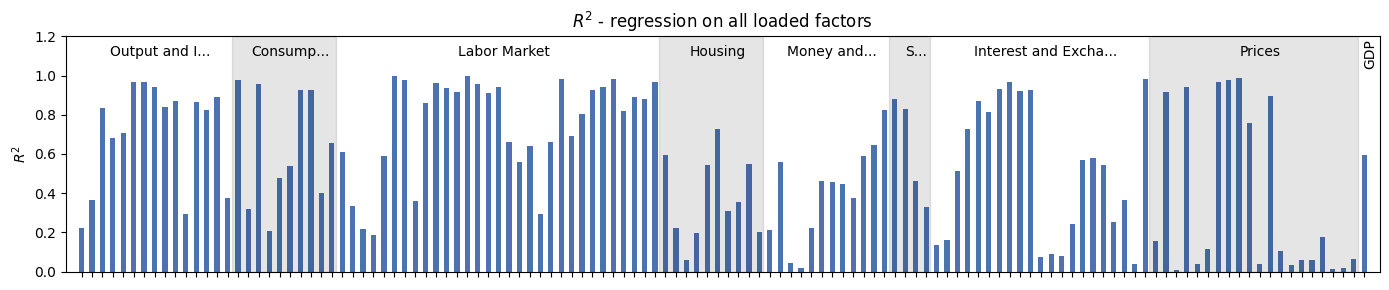

In [30]:
plot_r2_joint(results_global)

### Forecasting

One of the benefits of these models is that we can use the dynamics of the factors to produce forecasts of any of the observed variables. This is straightforward here, using the `forecast` or `get_forecast` results methods. These take a single argument, which must be either:

- an integer, specifying the number of steps ahead to forecast
- a date, specifying the date of the final forecast to make

The `forecast` method only produces a series of point forecasts for all of the observed variables, while the `get_forecast` method returns a new forecast results object, that can also be used to compute confidence intervals. 

**Note**: these forecasts are in the same scale as the variables passed to the `DynamicFactorMQ` constructor, even if `standardize=True` has been used.

Below is an example of the `forecast` method.

In [31]:
# results.forecast("2024-01")
# Create point forecasts, 3 steps ahead
point_forecasts = results.forecast(steps=3)

# Print the forecasts for the first 5 observed variables
print(point_forecasts.T.head())

                                            2023-01   2023-02   2023-03
Real Personal Income                       0.177280  0.324443  0.132304
Real personal income ex transfer receipts  0.076179  0.229756  0.240121
Real personal consumption expenditures     0.045532  0.369012  0.311025
Real Manu. and Trade Industries Sales     -0.018580  0.348917  0.285209
Retail and Food Services Sales             0.292237  0.656290  0.544410


In addition to `forecast` and `get_forecast`, there are two more general methods, `predict` and `get_prediction` that allow for both of in-sample prediction and out-of-sample forecasting. Instead of a `steps` argument, they take `start` and `end` arguments, which can be either in-sample dates or out-of-sample dates.

Below, we give an example of using `get_prediction` to show in-sample predictions and out-of-sample forecasts for some spreads between Treasury securities and the Federal Funds Rate.

In [32]:
# Create forecasts results objects, through the end of 2024
prediction_results = results.get_prediction(start='2000', end='2024')
prediction_results_global = results_global.get_prediction(start='2000', end='2024')

def plot_prediction(prediction_results, variables, start = '2000', end = '2024'):

    # The `predicted_mean` attribute gives the same
    # point forecasts that would have been returned from
    # using the `predict` or `forecast` methods.
    point_predictions = prediction_results.predicted_mean[variables]

    # We can use the `conf_int` method to get confidence
    # intervals; here, the 95% confidence interval
    ci = prediction_results.conf_int(alpha=0.05)
    lower = ci[[f'lower {name}' for name in variables]]
    upper = ci[[f'upper {name}' for name in variables]]

    latest = str(data.orig_m.index[-1])

    # Plot the forecasts and confidence intervals
    with sns.color_palette('deep'):
        fig, ax = plt.subplots(figsize=(14, 4))

        # Plot the in-sample predictions
        point_predictions.loc[:latest].plot(ax=ax)

        # Plot the out-of-sample forecasts
        point_predictions.loc[latest:].plot(ax=ax, linestyle='--',
                                            color=['C0', 'C1', 'C2'],
                                            legend=False)

        # Confidence intervals
        for name in variables:
            ax.fill_between(ci.index,
                            lower[f'lower {name}'],
                            upper[f'upper {name}'], alpha=0.1)
            
        # Forecast period, set title
        ylim = ax.get_ylim()
        ax.vlines(latest, ylim[0], ylim[1], linewidth=1)
        ax.annotate(r' Forecast $\rightarrow$', (latest, -1.7))
        ax.set(title='In-sample predictions and out-of-sample forecasts, with 95% confidence intervals', ylim=ylim)
        
        fig.tight_layout()

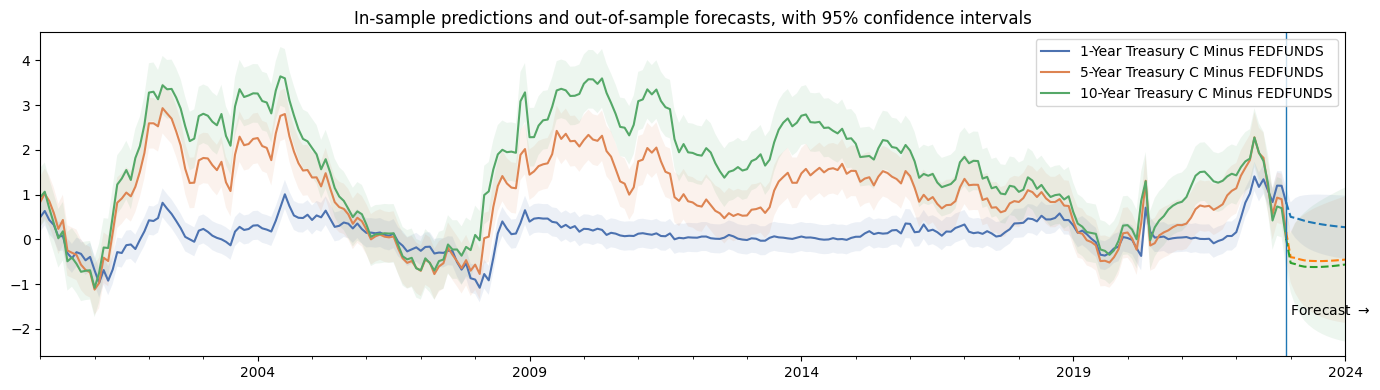

In [42]:
variables = ['1-Year Treasury C Minus FEDFUNDS',
             '5-Year Treasury C Minus FEDFUNDS',
             '10-Year Treasury C Minus FEDFUNDS']
             
plot_prediction(prediction_results, variables)

#### This Shows the model Prediction for real GDP

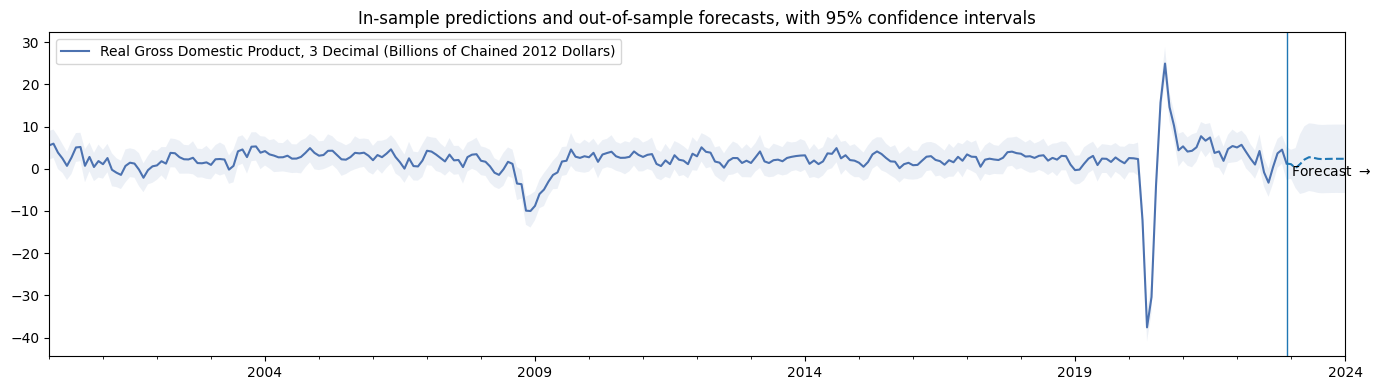

In [43]:
variables = ['Real Gross Domestic Product, 3 Decimal (Billions of Chained 2012 Dollars)'] 
             # 'Real Personal Income', 'Real personal consumption expenditures']

plot_prediction(prediction_results, variables)

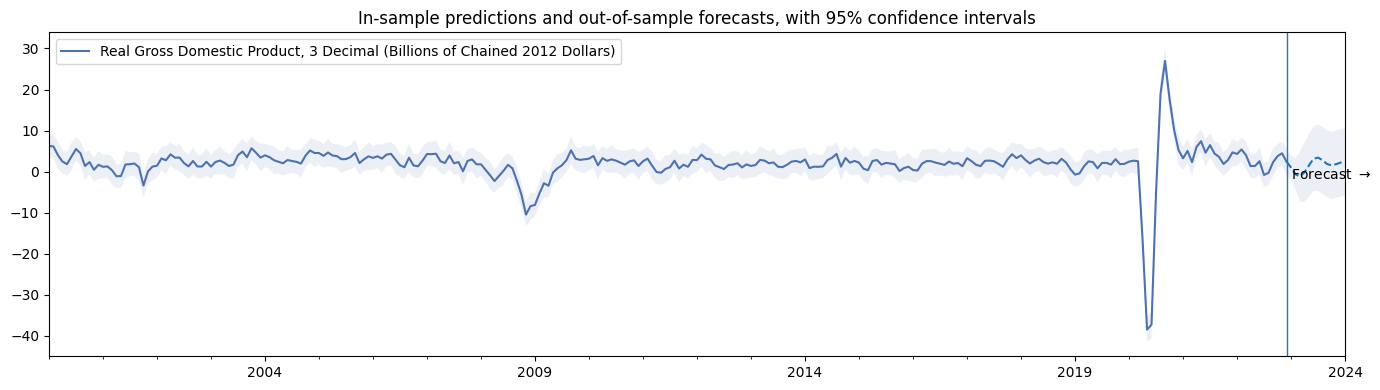

In [44]:
# Using Global Model
plot_prediction(prediction_results_global, variables)

#### Forecasting example

The variables that we showed in the forecasts above were not transformed from their original values. As a result, the predictions were already interpretable as spreads. For the other observed variables that were transformed prior to construting the model, our forecasts will be in the transformed scale.

For example, although the original data in the FRED-MD/QD datasets for Real GDP is in "Billions of Chained 2012 Dollars", this variable was transformed to the annualized quarterly growth rate (percent change) for inclusion in the model. Similarly, the Civilian Unemployment Rate was originally in "Percent", but it was transformed into the 1-month change (first difference) for inclusion in the model.

Below, we compute and plot the forecasts directly from the model associated with real GDP and the unemployment rate.

In [35]:
[x for x in dir(prediction_results) if not x.startswith("_")]

['conf_int',
 'dist',
 'dist_args',
 'model',
 'predicted_mean',
 'prediction_results',
 'row_labels',
 'se_mean',
 'summary_frame',
 't_test',
 'tvalues',
 'var_pred_mean']

In [53]:
# Get the titles of the variables as they appear in the dataset
unemp_description = 'Civilian Unemployment Rate'
gdp_description = 'Real Gross Domestic Product, 3 Decimal (Billions of Chained 2012 Dollars)'

latest = str(data.orig_m.index[-1])

def gen_data_forecast_mq(prediction_results, start = '2000', start_fc = '2023-01'):
    # Compute the point forecasts
    point_fcst = prediction_results.predicted_mean.loc[start_fc:, :]
    fcast_m = point_fcst[unemp_description]
    fcast_q = point_fcst[gdp_description].resample('Q').last()

    # For more convenient plotting, combine the observed data with the forecasts
    return (pd.concat([data.dta_m.loc[start:, unemp_description], fcast_m]),
            pd.concat([data.dta_q.loc[start:, gdp_description], fcast_q]))

plot_m, plot_q = gen_data_forecast_mq(prediction_results)
plot_m_gl, plot_q_gl = gen_data_forecast_mq(prediction_results_global)

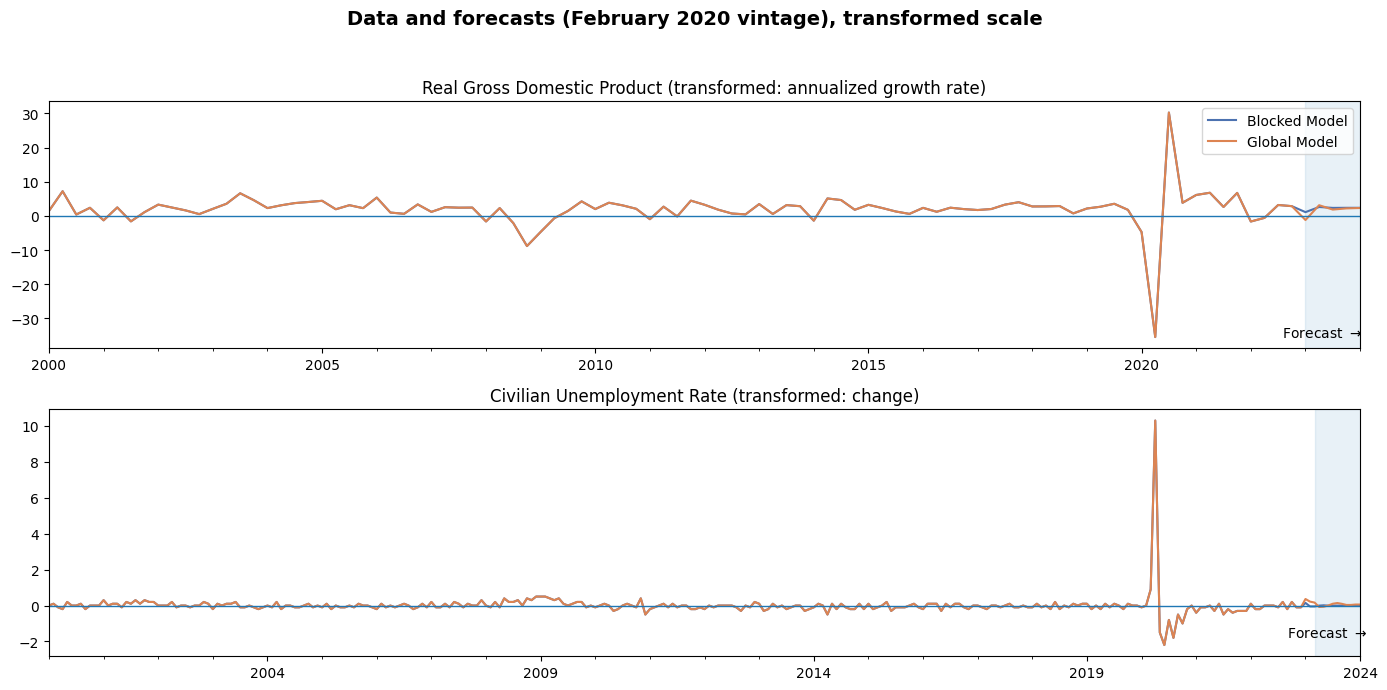

In [69]:
with sns.color_palette('deep'):
    fig, axes = plt.subplots(2, figsize=(14, 7))

    # Plot real GDP growth, data and forecasts
    plot_q.plot(ax=axes[0])
    plot_q_gl.plot(ax=axes[0])
    axes[0].set(title='Real Gross Domestic Product (transformed: annualized growth rate)')
    axes[0].hlines(0, plot_q.index[0], plot_q.index[-1], linewidth=1)
    axes[0].legend(["Blocked Model", "Global Model"])


    # Plot the change in the unemployment rate, data and forecasts
    plot_m.plot(ax=axes[1])
    plot_m_gl.plot(ax=axes[1])
    axes[1].set(title='Civilian Unemployment Rate (transformed: change)')
    axes[1].hlines(0, plot_m.index[0], plot_m.index[-1], linewidth=1)

    # Show the forecast period in each graph
    for i in range(2):
        ylim = axes[i].get_ylim()
        axes[i].fill_between(plot_q.loc['2023-01':].index,
                             ylim[0], ylim[1], alpha=0.1, color='C0')
        axes[i].annotate(r' Forecast $\rightarrow$',
                         ('2022-08', ylim[0] + 0.1 * ylim[1]))
        axes[i].set_ylim(ylim)

    # Title
    fig.suptitle('Data and forecasts, transformed scale',
                 fontsize=14, fontweight=600)

    fig.tight_layout(rect=[0, 0, 1, 0.95]);

In [56]:
# Reverse the transformations

# For real GDP, we take the level in 2000Q1 from the original data,
# and then apply the growth rates to compute the remaining levels
plot_q_orig = (plot_q / 100 + 1)**0.25
plot_q_orig.loc['2000Q1'] = data.orig_q.loc['2000Q1', gdp_description]
plot_q_orig = plot_q_orig.cumprod()

plot_q_gl_orig = (plot_q_gl / 100 + 1)**0.25
plot_q_gl_orig.loc['2000Q1'] = data.orig_q.loc['2000Q1', gdp_description]
plot_q_gl_orig = plot_q_gl_orig.cumprod()

# For the unemployment rate, we take the level in 2000-01 from
# the original data, and then we apply the changes to compute the
# remaining levels
plot_m_orig = plot_m.copy()
plot_m_orig.loc['2000-01'] = data.orig_m.loc['2000-01', unemp_description]
plot_m_orig = plot_m_orig.cumsum()

plot_m_gl_orig = plot_m_gl.copy()
plot_m_gl_orig.loc['2000-01'] = data.orig_m.loc['2000-01', unemp_description]
plot_m_gl_orig = plot_m_gl_orig.cumsum()

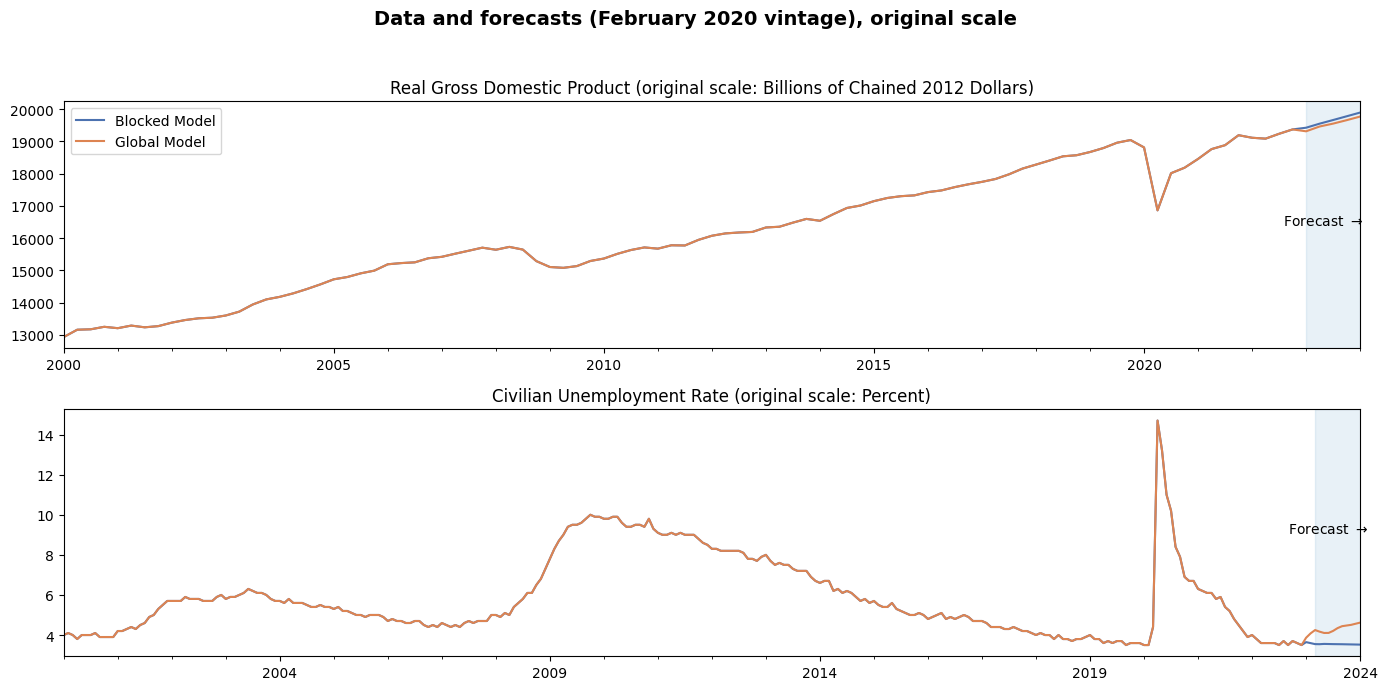

In [68]:
with sns.color_palette('deep'):
    fig, axes = plt.subplots(2, figsize=(14, 7))

    # Plot real GDP, data and forecasts
    plot_q_orig.plot(ax=axes[0], label = 'Blocked')
    plot_q_gl_orig.plot(ax=axes[0], label = 'Global')
    axes[0].set(title=('Real Gross Domestic Product'
                       ' (original scale: Billions of Chained 2012 Dollars)'))
    axes[0].legend(["Blocked Model", "Global Model"])

    # Plot the unemployment rate, data and forecasts
    plot_m_orig.plot(ax=axes[1])
    plot_m_gl_orig.plot(ax=axes[1])
    axes[1].set(title='Civilian Unemployment Rate (original scale: Percent)')

    # Show the forecast period in each graph
    for i in range(2):
        ylim = axes[i].get_ylim()
        axes[i].fill_between(plot_q.loc['2023-01':].index,
                             ylim[0], ylim[1], alpha=0.1, color='C0')
        axes[i].annotate(r' Forecast $\rightarrow$',
                         ('2022-08', ylim[0] + 0.5 * (ylim[1] - ylim[0])))
        axes[i].set_ylim(ylim)

    # Title
    fig.suptitle('Data and forecasts, original scale',
                 fontsize=14, fontweight=600)

    fig.tight_layout(rect=[0, 0, 1, 0.95]);